# Example of Traning a model

Train Base ViT model for IEEE EEG dataset

In [1]:
!pip install torchinfo

In [2]:
import os
import json
from datetime import datetime
import gc

import numpy as np
from tqdm.auto import tqdm, trange
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import warnings

# Run on Colab env
from google.colab import drive

drive.mount("/content/drive")
warnings.filterwarnings("ignore")


def join_path(*args):
    return os.path.join("/content/drive/MyDrive", *args)


def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Make sure that CUDA is available
assert torch.cuda.is_available(), "CUDA is not available"
device = torch.device("cuda")  # if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


## Settings

In [4]:
if not os.path.isdir(join_path("log")):
    os.mkdir(join_path("log"))

# Assign a unique ID to each experiment result
# use 'secrets.token_hex' if needed
current_time = datetime.now()
experiment_id = current_time.strftime("%y%m%d%H%M%S%f")
print("ID:", experiment_id)

experiment_name = "prototype"
print("Name:", experiment_name)

# Fix random seed
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)

# Settings
ARGS = {
    "id": experiment_id,
    "name": experiment_name,
    "model_path": join_path("log", f"{experiment_name}_{experiment_id}.pth"),
    "batch": 64,
    "grad_step": 1,
    "epochs": 3,
    "lr": 1e-4,
    "warmup_steps": 1,
    "weight_decay": 1e-2,
    "patience": 0,
}
DATA = {
    "train_path": join_path("data", "train.pt"),
    "test_path": join_path("data", "test.pt"),
    "val_path": join_path("data", "val.pt"),
    "channel": 19,
    "length": 2560,
    "labels": ["control", "ADHD"],
}
MODEL = {
    "embed_dim": 128,
    "num_heads": 4,
    "num_block": 4,
    "num_class": 2,
    "mlp_dim": 128 * 4,
    "dropout_p": 0.5,
}

ID: 250225144330444859
Name: prototype


## Utils

In [5]:
class EarlyStopping(object):
    """Stop training when loss does not decrease

    :param patience: number of epochs to wait before stopping
    :param path_to_save: path to save the best model
    """

    def __init__(self, patience, path_to_save):
        self._min_loss = float("inf")
        self._patience = patience
        self._path = path_to_save
        self.__check_point = None
        self.__counter = 0

    def should_stop(self, loss, model=None, epoch=None):
        """Check if training should stop.
        If 'model' or 'epoch' is None, the checkpoint will not be saved.

        :param loss: current loss
        :param model: model to save as checkpoint
        :param epoch: current epoch to mark check point
        :return: True if training should stop, False otherwise
        """
        if loss < self._min_loss:
            self._min_loss = loss
            self.__counter = 0
            if (model is not None) and (epoch is not None):
                self.__check_point = epoch
                torch.save(model.state_dict(), self._path)
        elif loss > self._min_loss:
            self.__counter += 1
            if self.__counter == self._patience:
                return True
        return False

    def load(self, weights_only=True):
        """Load best model weights

        :param weights_only: load only weights (default: True)
        :return: best model weights
        """
        return torch.load(self._path, weights_only=weights_only)

    @property
    def check_point(self):
        """Return check point index

        :return: check point index
        """
        if self.__check_point is None:
            raise ValueError("No check point is saved!")
        return self.__check_point

In [6]:
class WarmupScheduler(object):
    """Warmup learning rate and dynamically adjusts learning rate based on training loss.

    :param optimizer: torch optimizer
    :param initial_lr: initial learning rate
    :param min_lr: minimum learning rate
    :param warmup_steps: number of warmup steps
    :param decay_factor: decay factor
    """

    def __init__(
        self, optimizer, initial_lr, min_lr=1e-6, warmup_steps=10, decay_factor=10
    ):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.warmup_steps = warmup_steps
        self.decay_factor = decay_factor

        assert self.warmup_steps > 0, "Warmup steps must be greater than 0"
        assert self.decay_factor > 1, "Decay factor must be greater than 1"

        self.global_step = 1
        self.best_loss = float("inf")

        # Initialize learning rates
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = self.initial_lr * (self.global_step / self.warmup_steps)

    def step(self, loss):
        """Update learning rate based on current loss."""
        self.global_step += 1

        if self.global_step <= self.warmup_steps:
            # Linear warmup
            warmup_lr = self.initial_lr * (self.global_step / self.warmup_steps)
            for param_group in self.optimizer.param_groups:
                param_group["lr"] = warmup_lr
        else:
            # Check if loss increased
            if loss > self.best_loss:
                for param_group in self.optimizer.param_groups:
                    new_lr = max(param_group["lr"] / self.decay_factor, self.min_lr)
                    param_group["lr"] = new_lr
            self.best_loss = min(self.best_loss, loss)

    def get_lr(self):
        """Return current learning rates."""
        return [param_group["lr"] for param_group in self.optimizer.param_groups]

## Dataset

In [7]:
class EEGDataset(Dataset):
    def __init__(self, file_path):
        self.dataset = torch.load(file_path)
        self.eeg = self.dataset["data"]
        self.labels = self.dataset["label"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # eeg: FloatTensor to match weights and bias
        # labels: LongTensor for loss computation
        return self.eeg[idx].float(), self.labels[idx].long()

In [8]:
train_dataset = EEGDataset(DATA["train_path"])
val_dataset = EEGDataset(DATA["val_path"])
test_dataset = EEGDataset(DATA["test_path"])

# The training set is ordered; shuffle it to ensure randomness
train_dataloader = DataLoader(train_dataset, batch_size=ARGS["batch"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=ARGS["batch"])
test_dataloader = DataLoader(test_dataset, batch_size=ARGS["batch"])

## Model

In [9]:
class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super(AttentionBlock, self).__init__()
        self.embed_dim = embed_dim
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, embed_dim),
        )
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, input: torch.Tensor):
        torch._assert(
            input.shape[2] == self.embed_dim,
            f"Input shape must be (batch_size, seq_len, {self.embed_dim})",
        )

        # Multi-head Attention
        x, _ = self.attention(input, input, input, need_weights=False)

        # Add & Norm
        x_ = self.norm1(x + input)

        # Feed Forward
        x_ = self.mlp(x_)

        # Add & Norm
        x = self.norm2(x + x_)
        return x

In [10]:
class EEGTransformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        num_heads,
        num_block,
        num_class,
        seq_length,
        mlp_dim,
        dropout_p=0.0,
    ):
        super(EEGTransformer, self).__init__()
        self.dropout_p = dropout_p
        self.signal_channel = 19
        self.seq_length = seq_length

        # Embedding
        self.proj = nn.Conv1d(self.signal_channel, embed_dim, kernel_size=3, padding=1)
        self.pos_embedding = nn.Parameter(
            torch.empty(1, seq_length, embed_dim).normal_(std=0.02)
        )

        # Attention Blocks
        self.encoder = nn.ModuleList(
            [AttentionBlock(embed_dim, num_heads, mlp_dim) for _ in range(num_block)]
        )

        # Decoding layers
        self.global_max_pool = nn.Sequential(
            nn.AdaptiveMaxPool1d(1), nn.Dropout(p=self.dropout_p)
        )
        self.fc = nn.Sequential(
            nn.Flatten(1, -1),
            nn.Linear(embed_dim, num_class),
            nn.ReLU(),
            nn.Dropout(p=self.dropout_p),
        )

    def forward(self, input):
        torch._assert(
            input.shape[1:] == (self.signal_channel, self.seq_length),
            f"Expected shape of (batch, {self.signal_channel}, {self.seq_length})",
        )
        x = self.proj(input)

        # Self-attention requires shape of (batch, seq_len. embed_dim)
        x = x.permute(0, 2, 1)
        x = x + self.pos_embedding

        for layer in self.encoder:
            x = layer(x)

        x = x.permute(0, 2, 1)
        # x: (-1, embed_dim, seq_len)
        x = self.global_max_pool(x)
        x = self.fc(x)
        return x

In [11]:
model = EEGTransformer(
    embed_dim=MODEL["embed_dim"],
    num_heads=MODEL["num_heads"],
    num_block=MODEL["num_block"],
    num_class=MODEL["num_class"],
    seq_length=DATA["length"],
    mlp_dim=MODEL["mlp_dim"],
    dropout_p=MODEL["dropout_p"],
).to(device)

summary(model, (1, DATA["channel"], DATA["length"]))

Layer (type:depth-idx)                   Output Shape              Param #
EEGTransformer                           [1, 2]                    327,680
├─Conv1d: 1-1                            [1, 128, 2560]            7,424
├─ModuleList: 1-2                        --                        --
│    └─AttentionBlock: 2-1               [1, 2560, 128]            --
│    │    └─MultiheadAttention: 3-1      [1, 2560, 128]            66,048
│    │    └─LayerNorm: 3-2               [1, 2560, 128]            256
│    │    └─Sequential: 3-3              [1, 2560, 128]            131,712
│    │    └─LayerNorm: 3-4               [1, 2560, 128]            256
│    └─AttentionBlock: 2-2               [1, 2560, 128]            --
│    │    └─MultiheadAttention: 3-5      [1, 2560, 128]            66,048
│    │    └─LayerNorm: 3-6               [1, 2560, 128]            256
│    │    └─Sequential: 3-7              [1, 2560, 128]            131,712
│    │    └─LayerNorm: 3-8               [1, 2560, 128] 

## Train

In [12]:
def get_val_loss(model, criterion, val_loader, device):
    """Return validation loss"""
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for signal, label in val_loader:
            signal = signal.to(device)
            label = label.to(device)
            output = model(signal)

            batch_loss = criterion(output, label)
            val_loss += batch_loss.item()

        return val_loss / len(val_loader)


def train(model, optimizer, scheduler, criterion, train_loader, val_loader, device):
    """Train the model and return the best epoch"""
    model_path = ARGS["model_path"]
    grad_step = ARGS["grad_step"]
    epoch_trange = trange(1, ARGS["epochs"] + 1)
    early_stopper = EarlyStopping(ARGS["patience"], model_path)

    model.zero_grad()

    for epoch in epoch_trange:
        model.train()
        train_loss = 0
        for batch_id, (signal, label) in enumerate(train_loader, start=1):

            signal = signal.to(device)
            label = label.to(device)
            output = model(signal)

            batch_loss = criterion(output, label)
            train_loss += batch_loss.item()

            batch_loss /= grad_step
            batch_loss.backward()

            # Gradient Accumulation
            if batch_id % grad_step == 0:
                optimizer.step()
                model.zero_grad()

        # Validate Training Epoch
        train_loss /= len(train_loader)
        val_loss = get_val_loss(model, criterion, val_loader, device)
        tqdm.write(
            f"Epoch {epoch}, Train-Loss: {train_loss:.5f},  Val-Loss: {val_loss:.5f}"
        )

        # Early stopping
        if early_stopper.should_stop(val_loss, model, epoch):
            break

        # Learning Rate Scheduling
        scheduler.step(train_loss)

    check_point = early_stopper.check_point
    tqdm.write(f"\n--Check point: [Epoch: {check_point}]")

    return check_point

In [13]:
clear_cache()

loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(
    model.parameters(),
    lr=ARGS["lr"],
    weight_decay=ARGS["weight_decay"],
)
scheduler = WarmupScheduler(optimizer, ARGS["lr"], warmup_steps=ARGS["warmup_steps"])
check_point = train(
    model, optimizer, scheduler, loss_fn, train_dataloader, val_dataloader, device
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1, Train-Loss: 0.70245,  Val-Loss: 0.69343
Epoch 2, Train-Loss: 0.69059,  Val-Loss: 0.69263
Epoch 3, Train-Loss: 0.69030,  Val-Loss: 0.69426

--Check point: [Epoch: 2]


In [14]:
clear_cache()

# Model without Dropout(p=0.0) for inference
model = EEGTransformer(
    embed_dim=MODEL["embed_dim"],
    num_heads=MODEL["num_heads"],
    num_block=MODEL["num_block"],
    num_class=MODEL["num_class"],
    seq_length=DATA["length"],
    mlp_dim=MODEL["mlp_dim"],
    dropout_p=0.0,
).to(device)
trained_weights = torch.load(ARGS["model_path"], weights_only=True, map_location=device)
model.load_state_dict(trained_weights)

<All keys matched successfully>

## Evaluate

In [15]:
def evaluate(model, test_loader, device):
    """Return metrics for test set

    :returns metrics: { accuracy, f1-score, auc, roc-curve(fpr, tpr) }
    """
    model.eval()
    y_pred = list()
    y_true = list()

    with torch.no_grad():
        for signal, label in test_loader:
            signal = signal.to(device)
            output = model(signal)

            y_pred.extend(output.argmax(1).detach().cpu().numpy())
            y_true.extend(label.numpy())

        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        auc_value = auc(fpr, tpr)

        return {
            "accuracy": accuracy,
            "f1-score": f1,
            "auc": auc_value,
            "roc-curve": (fpr, tpr),
        }

In [16]:
metrics = evaluate(model, test_dataloader, device)

print(f"Accuracy: {metrics['accuracy']:.3f}")
print(f"F1-Score: {metrics['f1-score']:.3f}")
print(f"AUC: {metrics['auc']:.3f}")

Accuracy: 0.440
F1-Score: 0.000
AUC: 0.500


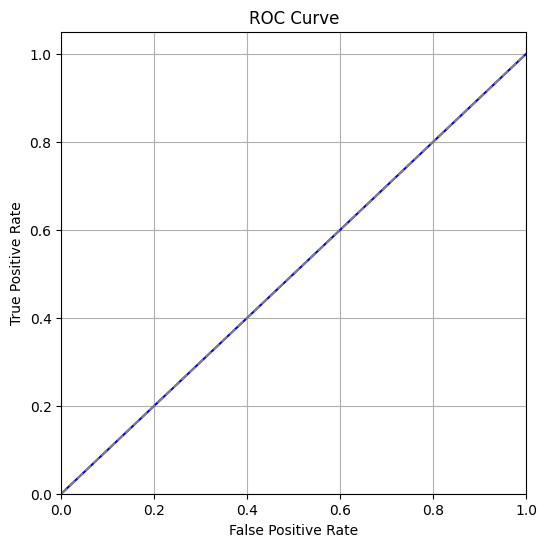

In [17]:
# Visualize ROC curve
plt.figure(figsize=(6, 6))
plt.plot(*metrics["roc-curve"], color="blue")
plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Baseline

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid()
plt.show()

## Log

In [18]:
# Log experiment result in json format
experiment_result = {
    "id": ARGS["id"],
    "name": ARGS["name"],
    "weights": ARGS["model_path"],
    "batch": (
        ARGS["batch"],
        ARGS["grad_step"],
    ),  # Batch size with Gradient Accumulation
    "lr": ARGS["lr"],
    "epochs": check_point,
    "num_heads": MODEL["num_heads"],
    "num_block": MODEL["num_block"],
    "num_class": MODEL["num_class"],
    "mlp_dim": MODEL["mlp_dim"],
    "dropout_p": MODEL["dropout_p"],
    "warmup_steps": ARGS["warmup_steps"],
    "weight_decay": ARGS["weight_decay"],
    "accuracy": metrics["accuracy"],
    "f1-score": metrics["f1-score"],
    "auc": metrics["auc"],
}

for key, value in experiment_result.items():
    print(f"{key}: {value}")

# Save result in json format
with open(join_path("log", f"{ARGS['name']}_{ARGS['id']}.json"), "w") as f:
    json.dump(experiment_result, f, indent=2)

id: 250225144330444859
name: prototype
weights: /content/drive/MyDrive/log/prototype_250225144330444859.pth
batch: (64, 1)
lr: 0.0001
epochs: 2
num_heads: 4
num_block: 4
num_class: 2
mlp_dim: 512
dropout_p: 0.5
warmup_steps: 1
weight_decay: 0.01
accuracy: 0.44025157232704404
f1-score: 0.0
auc: 0.5
